# STA 863 Final Project - FHMM
*Factorial Hidden Markov Models* - Gharamani and Jordan


In [137]:
import numpy as np
import pandas as pd
import csv
from numpy import linspace,exp
from numpy.random import randn
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.stats import multivariate_normal
import seaborn as sns
np.random.seed(17)

## 1. Generate Toy Data and Parameters

$$P({S_t, Y_t}) = P(S_1)P(Y_1 | S_1)\prod_{t=2}^T P(S_t | S_{t-1})P(Y_t | S_t)$$

- Assume three different chains, each with 5 hidden states each
- M = 3, K = (5, 5, 5)
- n = 10 observations, D = 3 (dimension of Gaussian)
- Normal Model

In [89]:
M = 3 ## Number of independent hidden state chains
K = np.array([5, 5, 5]) ## number of hidden states for each chain
D = 3 ## Dimension of Gaussian
n = 10 ## number of observations


## Generate distribtions
pi = [] ## initial distribution
Tmat = []  ## transition distribution
W = [] ## contribution to means matrices D x K
for i in range(0, M):
    vals = np.random.rand(K[i])
    pi.append(vals/np.sum(vals))
    vals1 = np.random.rand(K[i], K[i])
    Tmat.append(vals1/np.sum(vals1, axis=1)[:,None])
    W.append(10*np.random.rand(D, K[i]))
    
## Generate state variables
S = []
for i in range(0, M):
    zstates = np.arange(0, K[i], dtype = int)
    z = np.zeros(n, dtype = int)
    zmat = np.zeros((K[i], n), dtype = int)
    z[0] = np.random.choice(zstates, size = 1, p = pi[i])
    zmat[z[0], 0] = 1
    for j in range(1, n):
        z[j] = np.random.choice(zstates, size = 1, p = Tmat[i][z[j-1], :])
        zmat[z[j], j] = 1
    S.append(zmat)
#x = np.random.normal(size=D)
#y = np.random.normal(size=D)
#z = np.vstack((x, y))
#C = np.cov(z.T) ## covariance matrix
C = np.identity(D)
mu = np.zeros((D, n))
Y = np.zeros((D, n))
for t in range(0, n):
    for i in range(0, M):
        mu[:, t] += np.dot(W[i], S[i][:, t])
    Y[:, t] = np.random.multivariate_normal(mu[:, t], C, 1)


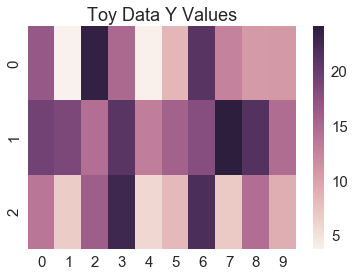

In [90]:
sns.heatmap(Y)
plt.title("Toy Data Y Values")
pass

# E - Step

## 2. Gibbs Sampling 

$$S_t^{(m)} \propto P(S_t^{(m)} | S_{t-1}^{(m)})P(S_{t+1}|S_t^{(m)})P(Y_t | S_t^{(1)}, \ldots, S_t^{(M)})$$

In [74]:
# t is the time step to be updated
# y is the observed value at that time step
# M is the number of hidden Markov chains
# K is a vector of number of hidden states for each chain
# C is covariance matrix for emission distribution
# W is a list of M D x K matrix, columns contribution to mean of each state variable 
# S is a M long list of current states, each element of list is K[i] x n long (n number of observations)
# update is which of M chains to calculate emission probabilities for, for every K[i] possible values
# output is a K[update] vector of density of y for each possible value of S[update]
def y_density(t, y, M, K, S, C, W, update):
    ydense = np.zeros(K[update]) ## output density for each possible value of S[update]
    Stemp = S
    for i in range(0, K[update]):
        mu = 0
        Stemp[update][:, t] = 0
        Stemp[update][i, t] = 0 # state variable value to calculate probability for
        for j in range(0, M):
            mu += np.dot(W[j], Stemp[j][:, t])
        ydense[i] = multivariate_normal.pdf(y, mean = mu, cov = C)
    return(ydense)



# n is the number of observations
# M is number of Markov hidden chains
# K is number of hidden states for each chain (1 x M vector)
# Y is the matrix of observations (D x n)
# Tmat is a list of M KxK transition matrices
# W is a list of M D x K matrix, columns contribution to mean of each state variable
# C is the covariance matrix for the observations
# it is the number of iterations to run for the Gibbs Sampler
# output is 
def gibbs_sampler(n, M, K, Y, Tmat, W, C, it = 10):
    # Randomly initialize state vectors
    S = []
    zstates = []
    for i in range(0, M):
        s = np.zeros((K[i], n), dtype = int)
        ind = np.random.choice(range(0, K[i]), n)
        s[ind, range(0, n)] = 1
        zz = np.zeros((it, n), dtype = int)
        zz[0, :] = ind
        zstates.append(zz)
        S.append(s)
        
    for l in range(1, it):
        ## update one  chain at a time
        for i in range(0, M):
            ## step through each time point
            for t in range(0, n):
                ## select P(S_t | S_t-1)
                if t == 0:
                    tback = np.ones(K[i])
                else:
                    prev = zstates[i][l-1, t-1]
                    tback = Tmat[i][prev, :]
                ## select P(S_t+1 | S_t)
                if t == (n-1):
                    tfore = np.ones(K[i])
                else:
                    fore = zstates[i][l-1, t]
                    tfore = Tmat[i][fore, :]
                ## calculate P(Y_t | S_t^1, S_t^2, ..., S_t^M)
                ydense = y_density(t, Y[:, t], M, K, S, C, W, i)
                
                ## Calculate probability for each state for S_t^i
                probvec = np.multiply(np.multiply(tback, tfore) , ydense)
                probvec = probvec/sum(probvec)
                ## sample state and update vector
                zstates[i][l, t] = np.random.choice(range(0, K[i]), 1, p = probvec)
                S[i][zstates[i][l, t], t] = 1
    
    ## Calculate expectations
                


array([[  1.19840172,   5.7943984 ,  19.05338194]])

In [149]:
S = []
zstates = []
for i in range(0, M):
    s = np.zeros((K[i], n), dtype = int)
    ind = np.random.choice(range(0, K[i]), n)
    s[ind, range(0, n)] = 1
    zz = np.zeros((it, n), dtype = int)
    zz[0, :] = ind
    zstates.append(zz)
    S.append(s)

for l in range(1, it):
    ## update one  chain at a time
    for i in range(0, M):
        ## step through each time point
        for t in range(0, n):
            ## select P(S_t | S_t-1)
            if t == 0:
                tback = np.ones(K[i])
            else:
                prev = zstates[i][l-1, t-1]
                tback = Tmat[i][prev, :]
            ## select P(S_t+1 | S_t)
            if t == (n-1):
                tfore = np.ones(K[i])
            else:
                fore = zstates[i][l-1, t]
                tfore = Tmat[i][fore, :]
            ## calculate P(Y_t | S_t^1, S_t^2, ..., S_t^M)
            ydense = y_density(t, Y[:, t], M, K, S, C, W, i)

            ## Calculate probability for each state for S_t^i
            probvec = np.multiply(np.multiply(tback, tfore) , ydense)
            probvec = probvec/sum(probvec)
            ## sample state and update vector
            zstates[i][l, t] = np.random.choice(range(0, K[i]), 1, p = probvec)
            S[i][zstates[i][l, t], t] = 1

In [150]:
zstates

[array([[1, 3, 2, 4, 2, 2, 3, 1, 3, 0],
        [3, 4, 3, 2, 4, 4, 0, 0, 2, 2],
        [4, 3, 4, 4, 3, 4, 2, 2, 0, 4],
        [4, 3, 4, 1, 4, 1, 0, 0, 2, 1],
        [1, 4, 3, 3, 1, 2, 2, 2, 1, 4],
        [4, 3, 1, 0, 2, 0, 2, 4, 4, 3],
        [4, 2, 2, 2, 2, 2, 2, 2, 4, 3],
        [1, 1, 4, 2, 4, 2, 0, 2, 4, 0],
        [2, 2, 3, 4, 3, 2, 0, 2, 0, 4],
        [2, 2, 4, 4, 2, 2, 2, 2, 1, 2]]),
 array([[1, 3, 3, 1, 0, 3, 0, 0, 2, 1],
        [1, 1, 1, 1, 3, 1, 4, 3, 3, 1],
        [1, 2, 2, 1, 0, 1, 4, 4, 1, 1],
        [3, 0, 0, 0, 0, 1, 0, 3, 4, 3],
        [1, 3, 3, 3, 4, 4, 4, 3, 4, 4],
        [3, 4, 1, 4, 4, 1, 4, 4, 4, 1],
        [0, 4, 1, 1, 4, 4, 2, 4, 4, 4],
        [0, 4, 1, 1, 3, 4, 4, 4, 4, 4],
        [1, 4, 3, 3, 1, 4, 4, 4, 4, 4],
        [0, 3, 4, 2, 3, 1, 1, 4, 1, 4]]),
 array([[4, 3, 4, 2, 0, 1, 0, 1, 1, 0],
        [0, 1, 1, 2, 1, 0, 0, 1, 1, 0],
        [1, 0, 2, 1, 0, 0, 0, 2, 2, 3],
        [2, 4, 0, 1, 4, 0, 0, 0, 2, 4],
        [2, 1, 0, 2, 0, 1, 0, 0, 3, 

In [154]:
np.multiply(np.multiply(tback, tfore) , ydense)

array([  2.70589632e-11,   6.95465156e-12,   1.35537626e-11,
         7.87565029e-12,   1.72893460e-11])

In [122]:
Tmat[0][np.where(S[0][:, 0] == 1)[0],]

array([[ 0.19996081,  0.20403249,  0.29195706,  0.18722926,  0.11682038],
       [ 0.21115863,  0.09142438,  0.33052367,  0.19078387,  0.17610944],
       [ 0.25710477,  0.06080759,  0.28033881,  0.05051779,  0.35123103],
       [ 0.24865014,  0.03889967,  0.22862993,  0.26022202,  0.22359825],
       [ 0.02973374,  0.27652913,  0.13364541,  0.26993288,  0.29015885]])

In [131]:
zstates

[array([3, 0, 2, 0, 4, 4, 4, 2, 2, 0]),
 array([3, 2, 2, 4, 0, 3, 2, 0, 4, 0]),
 array([2, 2, 1, 0, 1, 1, 4, 4, 4, 4])]

# M-Step

## 5. M-Step

$$ n = T$$
$$W^{new} = \left(\sum_{t=1}^T Y_t<S_t'>\right)\left(\sum_{t=1}^T<S_tS_t'>\right)^{\dagger}$$

** Add other update equations **

In [133]:
# M is number of hidden state Markov chains
# K is vector of number of hidden states for each Markov chain
# Y is the D x n matrix of observations
# St is a M long list of  K[i] x n matrices of the <S_t^(m)> expectations
# Smm is a M long list of K[m] x K[m] x n matrices of <S_t^(m)S_t^(m-1)'> expectations
# Snm is a sum(K) x sum(K) x n=T matrix of <S_t^(q)S_t^(m)'> expectations
# output is a tuple of updated values from the M step
# W is a M long list of D x K[m] matrices
# pi is a M long list of K[m] vectors for the initial distributions
# Tmat is a M long list of K[m] x K[m] transition matrices
# C is a D x D covariance matrix for the Gaussian observations
def Mstep(M, K,  Y, St, Smm, Snm):
    ### Update W ###
    # Concatenate St to be sum(K) x 1 x t
    cSt = np.concatenate(St)
    s1 = np.multiply(Y, cSt.transpose()) # first sum for Wnew
    s2 = np.linalg.pinv(np.sum(Snm, axis = 2)) # second sum for Wnew
    Wnew = np.multiply(s1, s2)
    # make Wnew back into list of matrices
    W = []
    pi = []
    ind1 = np.insert(np.cumsum(K[1:]), 0, 0)
    ind2 = K + np.insert(np.cumsum(K[1:]), 0, 0)
    for i in range(0, M):
        W.append(Wnew[:, ind1[i]:ind2[i]])
        ### Update pi ###
        pi.append(cSt[ind1[i]:ind2[i], 0])
    
    ### Update Transition matrices ###
    Tmat = []
    for i in range(0, M):
        Tnew = np.zeros((K[i], K[i]))
        for j in range(0, K[i]):
            for l in range(0, K[i]):
                Tnew[j,l] =  np.sum(Smm[i][j, l, :])/sum(St[i][l, 0:(n-1)])
        Tmat.append(Tnew)
        
    ### Update C covariance ###
    s1 = np.dot(Y, Y.transpose())/n
    s2 = np.zeros((D, D))
    for t in range(0, n):
        for i in range(0, M):
            mult1 = np.dot(W[i], St[i][:, t])
            s2 += np.dot(mult1, Y[:, t].transpose())
    C = s1 - s2/n
    
    return(W, pi, Tmat, C)

array([ 0.19996081,  0.20403249,  0.29195706,  0.18722926,  0.11682038])

In [202]:
np.dot(Y, Y.transpose())/n

array([[ 204.33394524,  235.31004905,  191.52872607],
       [ 235.31004905,  341.70406853,  236.02350824],
       [ 191.52872607,  236.02350824,  197.99066919]])

In [135]:
np.multiply(Tmat[0][zstates[0][0], :], Tmat[0][zstates[0][1], :])

array([ 0.04972028,  0.0079368 ,  0.06675012,  0.04872117,  0.02612083])

In [180]:
test = np.random.rand(3, 5)
tt = [2,3]
test

array([[ 0.32630789,  0.21268374,  0.44099242,  0.02005337,  0.80203217],
       [ 0.09690038,  0.24040777,  0.8267097 ,  0.46484536,  0.0639569 ],
       [ 0.05535868,  0.36112397,  0.18277368,  0.62832175,  0.69406504]])

In [196]:
#K + 
np.insert(np.cumsum(K[1:]), 0, 0)

array([ 0,  5, 10])

In [197]:
K + np.insert(np.cumsum(K[1:]), 0, 0)

array([ 5, 10, 15])

In [172]:
i = np.array([3, 3, 2])
0 + i[1:]

array([3, 2])

In [193]:
np.cumsum(K[1:])

array([ 5, 10])